In [34]:
library(htmlwidgets)
library(data.table)
library(dplyr)
library(ggplot2)
library(knitr)
library(stringr)
library(DT)
library(plotly)
library(arules)
library(arulesViz)
library(visNetwork)
library(igraph)
library(kableExtra)
library(RColorBrewer)

symptom_data = read.table(file = '../../data/nCoV2019/for_use/symptoms.tsv', sep = '\t', header = TRUE,
                           row.names = 1)

# Change all columns to be of type "logical"
for(i in c(1:ncol(symptom_data))) {
    symptom_data[,i] <- as.logical(symptom_data[,i])
}

# Adjust names

names(symptom_data) <- gsub(".", " ", names(symptom_data), fixed=TRUE)

head(symptom_data)

,abdominal pain,aches,aching muscles,acute coronary syndrome,acute myocardial infarction,acute pharyngitis,acute renal failure,acute respiratory disease,acute respiratory distress,acute respiratory failure,⋯,sweating,systemic weakness,toothache,transient fatigue,unwellness,vomiting,weak,weakness,wheezing,yes
,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,⋯,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
16,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE
137,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
151,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
164,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
224,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
379,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE


In [47]:
fever <- nrow(symptom_data[symptom_data['fever'] == TRUE,])
cough <- nrow(symptom_data[symptom_data['cough'] == TRUE,])
st <- nrow(symptom_data[symptom_data['sore throat'] == TRUE,])
total <- nrow(symptom_data)
print(sprintf("fever %s (%0.2f)", fever, fever/total))
print(sprintf("cough %s (%0.2f)", cough, cough/total))
print(sprintf("sore throat %s (%0.2f)", st, st/total))

[1] "fever 1003 (0.66)"
[1] "cough 562 (0.37)"
[1] "sore throat 120 (0.08)"


Number of cough values.

# Convert data frame to binary transaction matrix

In [2]:
symptom_data_transactions <- as(symptom_data, "transactions")
summary(symptom_data_transactions)

transactions as itemMatrix in sparse format with
 1520 rows (elements/itemsets/transactions) and
 142 columns (items) and a density of 0.01336175 

most frequent items:
      fever       cough sore throat     fatigue        mild     (Other) 
       1003         562         120          76          76        1047 

element (itemset/transaction) length distribution:
sizes
  1   2   3   4   5   6 
693 435 280  85  21   6 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   1.897   3.000   6.000 

includes extended item information - examples:
          labels      variables levels
1 abdominal pain abdominal pain   TRUE
2          aches          aches   TRUE
3 aching muscles aching muscles   TRUE

includes extended transaction information - examples:
  transactionID
1            16
2           137
3           151

In [3]:
f <- itemFrequency(symptom_data_transactions)
summary(f)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0006579 0.0013158 0.0013158 0.0133617 0.0064145 0.6598684 

pdf 
  3

png 
  2

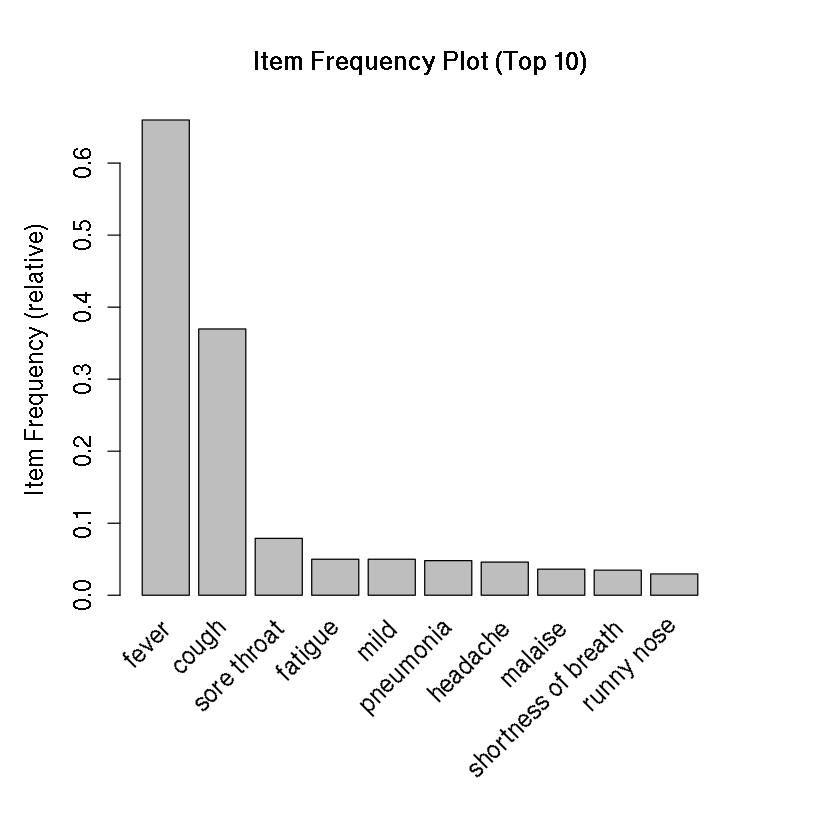

In [4]:
arules::itemFrequencyPlot(items(symptom_data_transactions),
    topN=10,
    cex.axis=1.3,
    cex.names=1.3,
    cex.lab=1.3,
    cex.main=1.3,
    support=0.02,
    main='Item Frequency Plot (Top 10)',
    type="relative",
    ylab="Item Frequency (relative)",
    names=TRUE,
    mai=c(2,1,1,1))
dev.copy(pdf, "symptoms-item-frequency.pdf")
dev.off()

# Mine rules/itemsets

In [5]:
#symptom_rules <- apriori(symptom_data_transactions, parameter=list(support=0.007, confidence=0.66, target="rules"))
symptom_rules <- apriori(symptom_data_transactions, parameter=list(support=0.004, confidence=0.7, target="rules"))
itemsets <- apriori(symptom_data_transactions, parameter=list(support=0.004, confidence=0.7, target="frequent itemsets"))
symptom_rules

Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.7    0.1    1 none FALSE            TRUE       5   0.004      1
 maxlen target   ext
     10  rules FALSE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 6 

set item appearances ...[0 item(s)] done [0.00s].
set transactions ...[142 item(s), 1520 transaction(s)] done [0.00s].
sorting and recoding items ... [39 item(s)] done [0.00s].
creating transaction tree ... done [0.00s].
checking subsets of size 1 2 3 4 done [0.00s].
writing ... [47 rule(s)] done [0.00s].
creating S4 object  ... done [0.00s].
Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
         NA    0.1    1 none FALSE            TRUE       5   0.004      1
 maxlen            target   ext
     10 frequent itemsets FALSE

Algorithmic control:
 filter tree heap 

set of 47 rules 

Itemsets in Antecedent (LHS)
 [1] "{between others,cough,fever}"       "{between others,fever}"            
 [3] "{between others,cough}"             "{moderate}"                        
 [5] "{between others}"                   "{acute respiratory failure}"       
 [7] "{septic shock}"                     "{bone pain,fever}"                 
 [9] "{between others,fever,muscle pain}" "{fever,sputum}"                    
[11] "{fever,muscle pain}"                "{body ache}"                       
[13] "{bone pain}"                        "{between others,muscle pain}"      
[15] "{fever,nasal congestion}"           "{fever,shortness of breath}"       
[17] "{sputum}"                           "{bone pain,cough}"                 
[19] "{cough,nasal congestion}"           "{cough,myalgia}"                   
[21] "{cough,nausea}"                     "{cough,phlegm}"                    
[23] "{between others,cough,muscle pain}" "{cough,muscle pain}"               
[25] "{joint pain}"    

pdf 
  3

png 
  2

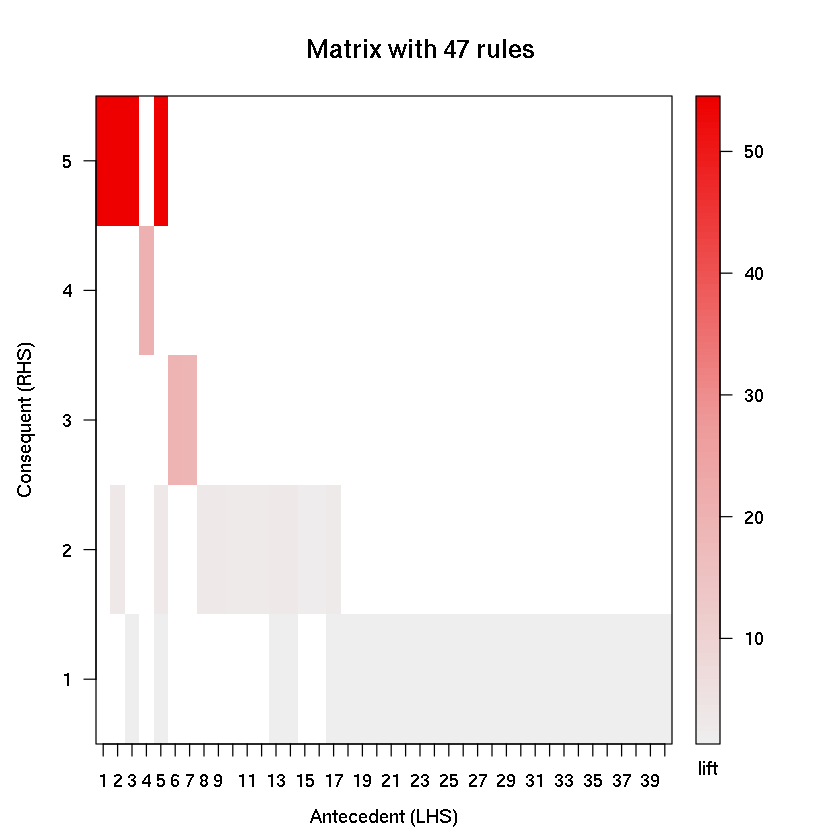

In [6]:
plot(symptom_rules, method="matrix", measure="lift")
dev.copy(pdf, "symptoms-matrix.pdf")
dev.off()

pdf 
  3

png 
  2

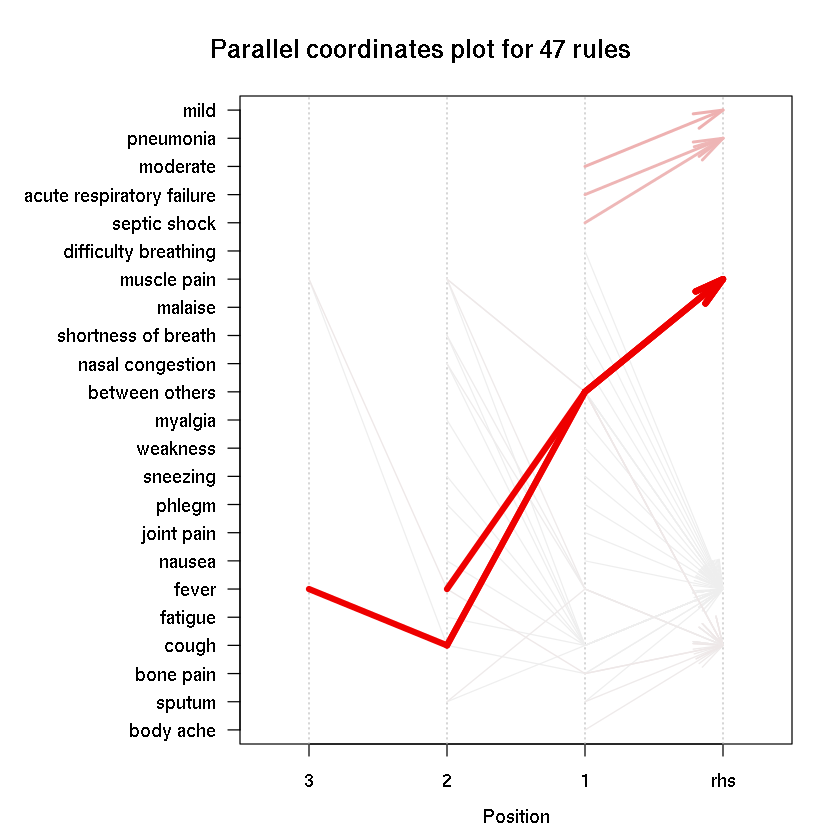

In [7]:
plot(symptom_rules, method="paracoord", control=list(reorder=TRUE), measure="lift")
dev.copy(pdf, "symptoms-paracoord.pdf")
dev.off()

# Graph rules

pdf 
  3

png 
  2

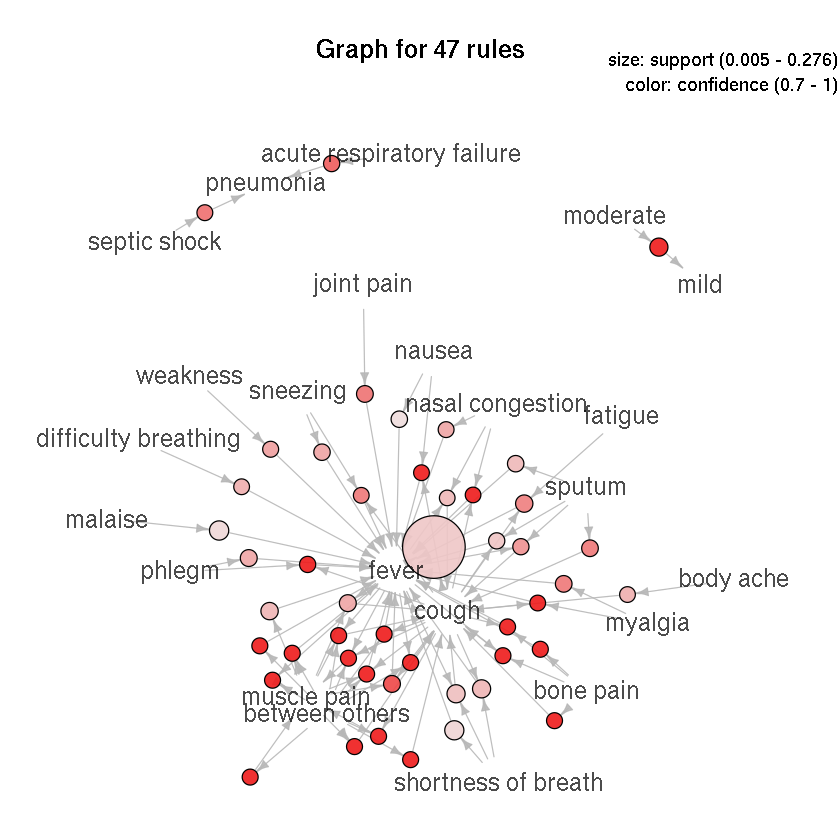

In [8]:
#plot(symptom_rules, method="graph", control=list(layout=igraph::in_circle()))
#plot(symptom_rules, method="graph", control=list(layout=igraph::with_graphopt(spring.const=1, mass=100)))

set.seed(11)
plot(symptom_rules, method="graph", cex=1.3, measure="support", shading="confidence", alpha=0.9)
dev.copy(pdf, "symptoms-rules.pdf")
dev.off()

# Interactive graph

## Confidence

In [9]:
set.seed(11)
p <- plot(symptom_rules, method="graph", measure="support", shading="confidence", engine="htmlwidget")
htmlwidgets::saveWidget(p, "symptoms-rules-confidence.html", title="Rules generated from COVID-19 Symptoms",
                        selfcontained = TRUE)

## Lift

In [10]:
set.seed(11)
p <- plot(symptom_rules, method="graph", measure="support", shading="lift", engine="htmlwidget")
htmlwidgets::saveWidget(p, "symptoms-rules-lift.html", title="Rules generated from COVID-19 Symptoms",
                        selfcontained = TRUE)